In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import albumentations as albu
import torch
import segmentation_models_pytorch as smp

/home/rmahajani31/anaconda3/envs/HubMapEnv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

In [3]:
DATA_DIR = './'
x_train_dir = os.path.join(DATA_DIR, 'dataset1_files/all_dataset1_imgs_merged_train_0')
y_train_dir = os.path.join(DATA_DIR, 'dataset1_files/all_dataset1_masks_merged_train_0')

x_valid_dir = os.path.join(DATA_DIR, 'dataset1_files/all_dataset1_imgs_merged_validation_0')
y_valid_dir = os.path.join(DATA_DIR, 'dataset1_files/all_dataset1_masks_merged_validation_0')

x_test_dir = os.path.join(DATA_DIR, 'dataset1_files/all_dataset1_imgs_merged_validation_0')
y_test_dir = os.path.join(DATA_DIR, 'dataset1_files/all_dataset1_masks_merged_validation_0')

In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [5]:
class HubMapDataset(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['unlabelled', 'blood_vessel']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return self.images_fps[i], image, mask
        
    def __len__(self):
        return len(self.ids)

In [7]:
def get_training_augmentation_simple():
  train_transform = [
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
  ]
  return albu.Compose(train_transform)
  
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=512, min_width=352, always_apply=True, border_mode=0),
        albu.RandomCrop(height=512, width=352, always_apply=True),

        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(512, 512)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

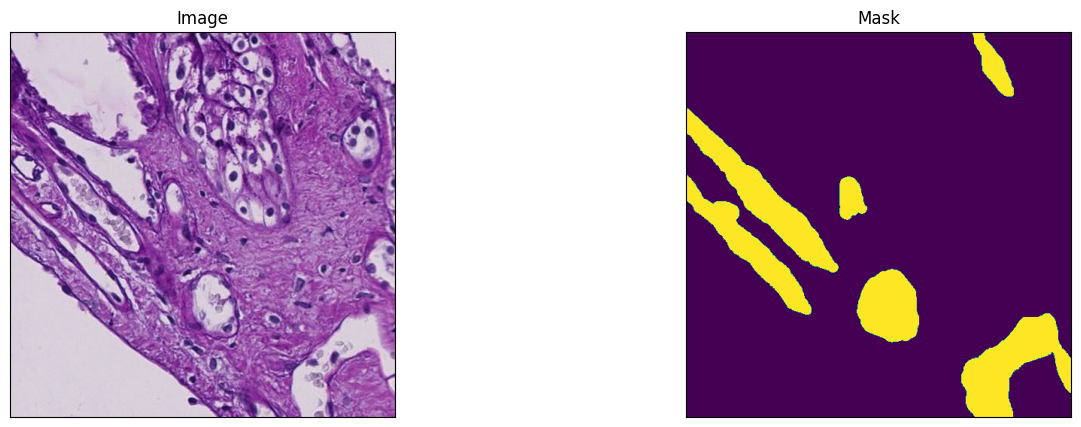

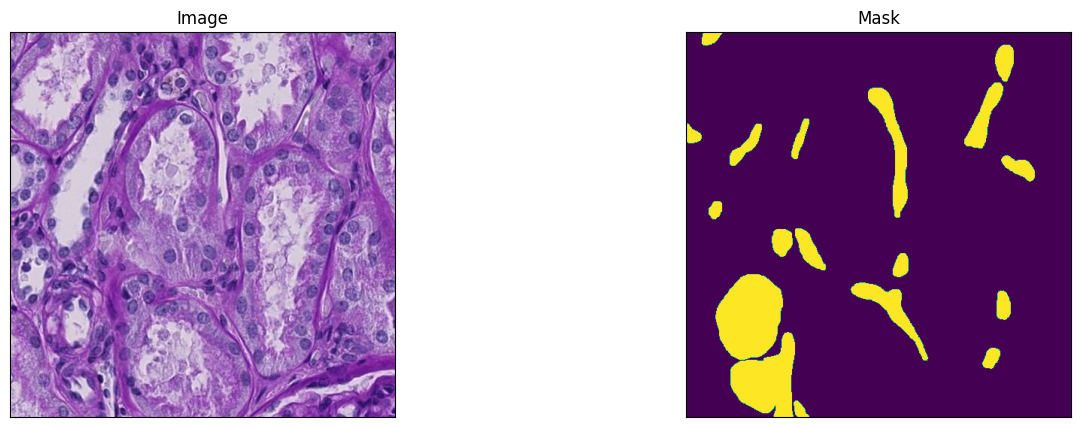

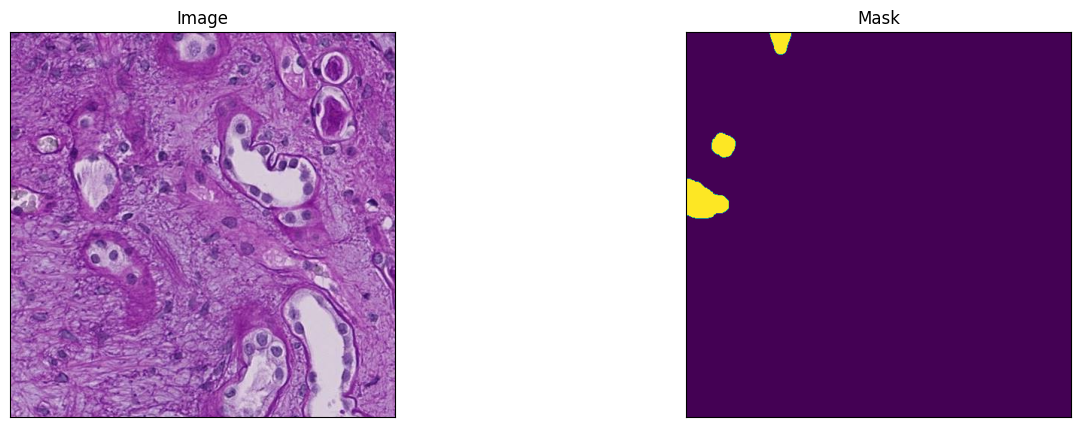

In [8]:
augmented_dataset = HubMapDataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation_simple(), 
    classes=['blood_vessel'],
)
# same image with different random transforms
for i in range(3):
    _, image, mask = augmented_dataset[i]
    visualize(image=image, mask=mask.squeeze(-1))

In [9]:
CLASSES = ['unlabelled', 'blood_vessel']
ENCODER = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'

In [10]:
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=3,
    classes=len(CLASSES)
)

In [11]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [12]:
train_dataset = HubMapDataset(
    x_train_dir, 
    y_train_dir,  
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = HubMapDataset(
    x_valid_dir, 
    y_valid_dir, 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2)

In [13]:
from torchmetrics import Metric
class IoUScore(Metric):
    def __init__(self, threshold=0.5, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.threshold = threshold
        self.add_state("iou_scores_back", default=[], dist_reduce_fx="sum")
        self.add_state("iou_scores_front", default=[], dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        preds = (preds > self.threshold).int()
        intersection_back = torch.logical_and(preds[:,0,:,:], target[:,0,:,:]).sum()
        union_back = torch.logical_or(preds[:,0,:,:], target[:,0,:,:]).sum()
        intersection_fore = torch.logical_and(preds[:,1,:,:], target[:,1,:,:]).sum()
        union_fore = torch.logical_or(preds[:,1,:,:], target[:,1,:,:]).sum()
        self.iou_scores_back.append(intersection_back.float() / union_back.float())
        self.iou_scores_front.append(intersection_fore.float() / union_fore.float())
    
    def compute(self):
        iou_back = np.mean(self.iou_scores_back)
        iou_fore = np.mean(self.iou_scores_front)
        self.iou_scores_back = []
        self.iou_scores_front = []
        return iou_back,iou_fore

In [14]:
loss = smp.losses.DiceLoss(mode='multiclass', from_logits=True)
metrics = [
    IoUScore(threshold=0.5).to(DEVICE),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [15]:
from tqdm import tqdm
# Training loop
def train_epoch(model, metrics, optimizer, device, dataloader):
    model.train()
    num_batches = len(dataloader)
    total_loss = 0
    print(f'Processing a total of {num_batches} batches in training')
    # Iterate over the training dataset
    for batch_idx, (f, inputs, targets) in tqdm(enumerate(dataloader)):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
#         print(f'input and output shapes: {inputs.shape}, {outputs.shape}, {targets.shape}')
#         print(f'Outputs min: {torch.min(outputs)}, Outputs max: {torch.max(outputs)}')
        loss = loss_fn(outputs, targets)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Compute metrics
        for metric in metrics:
            metric.update(torch.softmax(outputs, dim=1), targets)
        total_loss += loss
    metric_values = [float(total_loss)/num_batches] + [metric.compute() for metric in metrics]
    return metric_values

def valid_epoch(model, metrics, device, dataloader):
    model.eval()
    num_batches = len(dataloader)
    total_loss = 0
    print(f'Processing a total of {num_batches} batches in validation')
    # Disable gradient calculation
    with torch.no_grad():
        # Iterate over the validation dataset
        for batch_idx, (f, inputs, targets) in tqdm(enumerate(dataloader)):
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            # Compute metrics
            for metric in metrics:
                metric.update(torch.softmax(outputs, dim=1), targets)
            total_loss += loss
    # Get the metric values
    metric_values = [float(total_loss)/num_batches] + [metric.compute() for metric in metrics]
    return metric_values

In [16]:
# import time
# from sklearn.model_selection import KFold
# from torch.utils.data import Subset
# num_folds = 5

# kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
# num_epochs = 50

# for i in range(0, num_folds):
#   if os.path.exists(f'./models/model_stats_unet_dataset1_fold_{i}.txt'):
#     os.remove(f'./models/model_stats_unet_dataset1_fold_{i}.txt')

# for fold, (train_indices, valid_indices) in enumerate(kfold.split(train_dataset)):
#   cur_train_dataset = Subset(train_dataset, train_indices)
#   cur_valid_dataset = Subset(train_dataset, valid_indices)
#   train_loader = DataLoader(cur_train_dataset, batch_size=4, shuffle=True, num_workers=2)
#   valid_loader = DataLoader(cur_valid_dataset, batch_size=4, shuffle=False, num_workers=2)
#   max_iou = 0
#   print(f'Starting fold {fold} with dataset sizes: {len(cur_train_dataset)}, {len(cur_valid_dataset)}')
#   data_parallel = False
#   model = smp.Unet(
#     encoder_name=ENCODER,
#     encoder_weights=ENCODER_WEIGHTS,
#     in_channels=3,
#     classes=len(CLASSES)
#     )
#   model = model.to(DEVICE)
#   model = nn.DataParallel(model) if data_parallel else model
#   optimizer = torch.optim.Adam([
#     dict(params=model.parameters(), lr=0.0001),
#   ])
#   num_continuous_unsaved_epochs = 0
#   for epoch in range(num_epochs):
#       # Training
#       start_time = time.time()
#       train_metrics = train_epoch(model, metrics, optimizer, DEVICE, train_loader)
#       print(f'=========Finished Training Epoch {epoch} in {float(time.time()-start_time)/60}==========')
#       # Validation
#       start_time = time.time()
#       valid_metrics = valid_epoch(model, metrics, DEVICE, valid_loader)
#       print(f'=========Finished Validation Epoch {epoch} {float(time.time()-start_time)/60}in =========')

#       cur_validation_iou = 0.5*valid_metrics[1][0] + 0.5*valid_metrics[1][1]
#       if cur_validation_iou > max_iou:
#         print(f'Saving model with IoU: {cur_validation_iou}...')
#         torch.save(model, f'./models/best_model_unet_dataset1_fold_{fold}.pth')
#         with open(f'./models/best_model_unet_dataset1_fold_{fold}.txt', 'w') as f:
#           f.write(f"Epoch {epoch}: Train Loss={train_metrics[0]}, Validation Loss={valid_metrics[0]}, Train IoU Back={train_metrics[1][0]}, Train IoU Fore={train_metrics[1][1]}, Validation IoU Back={valid_metrics[1][0]}, Validation IoU Fore={valid_metrics[1][1]}")
#         max_iou = cur_validation_iou
#         num_continuous_unsaved_epochs = 0
#       else:
#         num_continuous_unsaved_epochs += 1
#       print(f"Epoch {epoch}: Train Loss={train_metrics[0]}, Validation Loss={valid_metrics[0]}, Train IoU Back={train_metrics[1][0]}, Train IoU Fore={train_metrics[1][1]}, Validation IoU Back={valid_metrics[1][0]}, Validation IoU Fore={valid_metrics[1][1]}")
#       with open(f'./models/model_stats_unet_dataset1_fold_{fold}.txt', 'a') as fp:
#         fp.write(f"Epoch {epoch}: Train Loss={train_metrics[0]}, Validation Loss={valid_metrics[0]}, Train IoU Back={train_metrics[1][0]}, Train IoU Fore={train_metrics[1][1]}, Validation IoU Back={valid_metrics[1][0]}, Validation IoU Fore={valid_metrics[1][1]}\n")
#         fp.flush()
#       if num_continuous_unsaved_epochs == 7:
#           break

In [17]:
# This is a block to run training without cross validation
import time
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=2)
max_iou = 0
num_epochs = 50
if os.path.exists('./models/model_stats_unet_dataset1.txt'):
 os.remove('./models/model_stats_unet_dataset1.txt')
fp = open('./models/model_stats_unet_dataset1.txt', 'a')
for epoch in range(num_epochs):
   # Training
   start_time = time.time()
   train_metrics = train_epoch(model, metrics, optimizer, DEVICE, train_loader)
   print(f'=========Finished Training Epoch {epoch} in {float(time.time()-start_time)/60}==========')
   # Validation
   start_time = time.time()
   valid_metrics = valid_epoch(model, metrics, DEVICE, valid_loader)
   print(f'=========Finished Validation Epoch {epoch} {float(time.time()-start_time)/60}in =========')

   save_interval = 10
   if (epoch+1) % 10 == 0:
       torch.save(model, f'./models/model_{epoch}_unet_dataset1.pth')

   cur_validation_iou = 0.5*valid_metrics[1][0] + 0.5*valid_metrics[1][1]
   if cur_validation_iou > max_iou:
     print(f'Saving model with IoU: {cur_validation_iou}...')
     torch.save(model, './models/best_model_unet_dataset1.pth')
     with open('./models/best_model_unet_dataset1.txt', 'w') as f:
       f.write(f"Epoch {epoch}: Train Loss={train_metrics[0]}, Validation Loss={valid_metrics[0]}, Train IoU Back={train_metrics[1][0]}, Train IoU Fore={train_metrics[1][1]}, Validation IoU Back={valid_metrics[1][0]}, Validation IoU Fore={valid_metrics[1][1]}")
     max_iou = cur_validation_iou
   print(f"Epoch {epoch}: Train Loss={train_metrics[0]}, Validation Loss={valid_metrics[0]}, Train IoU Back={train_metrics[1][0]}, Train IoU Fore={train_metrics[1][1]}, Validation IoU Back={valid_metrics[1][0]}, Validation IoU Fore={valid_metrics[1][1]}")
   fp.write(f"Epoch {epoch}: Train Loss={train_metrics[0]}, Validation Loss={valid_metrics[0]}, Train IoU Back={train_metrics[1][0]}, Train IoU Fore={train_metrics[1][1]}, Validation IoU Back={valid_metrics[1][0]}, Validation IoU Fore={valid_metrics[1][1]}\n")
   fp.flush()
fp.close()

Processing a total of 1175 batches in training


0it [00:00, ?it/s]Exception ignored in: <generator object tqdm.__iter__ at 0x7f11800c9700>
Traceback (most recent call last):
  File "/home/rmahajani31/anaconda3/envs/HubMapEnv/lib/python3.10/site-packages/tqdm/std.py", line 1193, in __iter__
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
# Inference
from collections import OrderedDict
data_parallel_model = True
model_path = './models/unet-dataset1-batch-size-8-models/best_model_unet_dataset1.pth'
if data_parallel_model:
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    checkpoint_state = checkpoint.state_dict()
    modified_checkpoint_state = OrderedDict()
    for key, value in checkpoint_state.items():
      new_key = key[len('module.'):]
      modified_checkpoint_state[new_key] = value
    best_model = torch.load('./models/starter_model.pth', map_location=torch.device('cpu'))
    best_model.load_state_dict(modified_checkpoint_state)
    best_model = best_model.to(DEVICE)
else:
    best_model = torch.load(model_path, map_location=torch.device('cpu'))
    best_model = best_model.to(DEVICE)

In [ ]:
CLASSES = ['unlabelled', 'blood_vessel']
test_dataset = HubMapDataset(
    x_test_dir, 
    y_test_dir, 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_loader = DataLoader(test_dataset)

In [ ]:
valid_metrics = valid_epoch(best_model, loss, metrics, DEVICE, test_loader)
print(f'Test Loss: {valid_metrics[0]}, Test IoU: {valid_metrics[1]}')

In [ ]:
test_dataset_without_aug = HubMapDataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)
train_dataset_without_aug = HubMapDataset(
    x_train_dir, y_train_dir, 
    classes=CLASSES,
)

In [ ]:
target_dataset = test_dataset
target_dataset_without_aug = test_dataset_without_aug
for i in range(20):
    n = np.random.choice(len(target_dataset))
    
    image_vis = target_dataset_without_aug[n][0].astype('uint8')
    image, gt_mask = target_dataset[n]
    image_trans = image.transpose(1,2,0)
    print(f'image tran shape: {image_trans.shape}')
    print(image.shape, gt_mask.shape)
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    print(x_tensor.shape)
    pr_mask = torch.sigmoid(best_model.predict(x_tensor))
    print(pr_mask.shape)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    print(pr_mask.shape)
    
    visualize(
        image=image_trans, 
        ground_truth_mask=gt_mask[1,:,:], 
        predicted_mask=pr_mask[1,:,:]
    )

In [ ]:
visualize(
        image=image_trans, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

In [ ]:
print(pr_mask.shape)
print(pr_mask)
plt.imshow(pr_mask)
# im2, contours, hierarchy = cv2.findContours(pr_mask.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)